<p p style = "font-family: garamond; font-size:40px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">G2Net Gravitational Waves</p>

![](https://www.g2net.eu/wp-content/uploads/2021/03/Acoustic_sound_wave_quantum_research-1170x600.jpg)


<p p style = "font-family: garamond; font-size:40px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">What are we discussing today? </p>
 <p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#006699; border-radius: 10px 10px; text-align:center"> Constant Q Transform<br>
 GPU Efficient Network <br>
 FastAI <br>
 Test Time Augmentation <br>
 Weights and Biases for Experiment Tracking

<p p style = "font-family: garamond; font-size:35px; font-style: normal;background-color: #f6f5f5; color :#ff0066; border-radius: 10px 10px; text-align:center">Upvote the kernel if you find it insightful!</p>

<center><img src="https://i.imgur.com/gb6B4ig.png" width="400" alt="Weights & Biases" /></center><br>
<p style = "font-family: garamond; font-size: 20px; font-style: normal; border-radius: 10px 10px; text-align:center">Wandb is a developer tool for companies turn deep learning research projects into deployed software by helping teams track their models, visualize model performance and easily automate training and improving models.
We will use their tools to log hyperparameters and output metrics from your runs, then visualize and compare results and quickly share findings with your colleagues.<br><br>We'll be using this to train our K Fold Cross Validation and gain better insights about our training. <br><br></p>

![img](https://i.imgur.com/BGgfZj3.png)

In [1]:
!pip install -q --upgrade wandb 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.5.0 requires wandb<0.11.0,>=0.10.0, but you have wandb 0.11.1 which is incompatible.


<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Import GPU Efficient Network from Github</p>

In [2]:
!git clone https://github.com/idstcv/GPU-Efficient-Networks.git

Cloning into 'GPU-Efficient-Networks'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 99 (delta 48), reused 66 (delta 30), pack-reused 0
Unpacking objects: 100% (99/99), done.


In [3]:
cd ./GPU-Efficient-Networks

/kaggle/working/GPU-Efficient-Networks


In [4]:
import GENet

In [5]:
cd ../

/kaggle/working


<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Import Libraries</p>

In [6]:
# Python library to interact with the file system.
import os

#Visualization
import plotly.express as px


# Software library written for data manipulation and analysis.
import pandas as pd

# fastai library for computer vision tasks
from fastai.vision.all import *
from fastai.callback.wandb import *

# Developing and training neural network based deep learning models.
import torch
from torch import nn

# Python library for image augmentation
import albumentations as A


import wandb
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Define Seed for Reproducibility</p>

In [7]:
def set_seed(dls, x=42): 
    random.seed(x)
    dls.rng.seed(x) 
    np.random.seed(x)
    torch.manual_seed(x)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed_all(x)
    

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Load Train and Test</p>

In [8]:
path = Path('../input/g2net-constant-q-transformed')

In [9]:
train_df = pd.read_csv(path/'training_labels.csv')
train_df

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1
...,...,...
559995,ffff9a5645,1
559996,ffffab0c27,0
559997,ffffcf161a,1
559998,ffffd2c403,0


In [10]:
train_df['id'] = train_df['id'].map(lambda x : f'{path}/train_cqt/train_cqt/{x}.png' )
train_df.head()

,id,target
0,../input/g2net-constant-q-transformed/train_cqt/train_cqt/00000e74ad.png,1
1,../input/g2net-constant-q-transformed/train_cqt/train_cqt/00001f4945.png,0
2,../input/g2net-constant-q-transformed/train_cqt/train_cqt/0000661522.png,0
3,../input/g2net-constant-q-transformed/train_cqt/train_cqt/00007a006a.png,0
4,../input/g2net-constant-q-transformed/train_cqt/train_cqt/0000a38978.png,1


In [11]:

train_df = train_df.sample(frac=0.1, random_state=42)
train_df = train_df.reset_index(drop=True)
len(train_df)

56000

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Minimal EDA</p>

In [12]:
dist = train_df.target.map({0:'Target 0', 1:'Target 1'})
dist = dist.value_counts()
fig = px.pie(dist,
             values='target',
             names=dist.index,
             hole=.4,title="Target Distribution")
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Create Dataloaders</p>

In [13]:
# obtain the input images.
def get_x(r):
    return r['id']

# obtain the targets.
def get_y(r):
    return r['target']

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Albumentations with FastAI</p>

<p style = "font-family: garamond; font-size: 20px; font-style: normal; border-radius: 10px 10px; text-align:center"> The Albumentation code has been borrowed from Fastai docs. It's very common to use different transforms on the training dataset versus the validation dataset. Lets see how!<br>
Albumentations is a Python library for image augmentation. Image augmentation is used in deep learning and computer vision tasks to increase the quality of trained models. The purpose of image augmentation is to create new training samples from the existing data.<br><br>
📍 Albumentations supports all common computer vision tasks such as classification, semantic segmentation, instance segmentation, object detection, and pose estimation.<br>
📍 The library provides a simple unified API to work with all data types: images (RBG-images, grayscale images, multispectral images), segmentation masks, bounding boxes, and keypoints.<br>
📍 The library contains more than 70 different augmentations to generate new training samples from the existing data.<br>
📍 Albumentations is fast.<br>


In [14]:
'''AlbumentationsTransform will perform different transforms over both
   the training and validation datasets ''' 
class AlbumentationsTransform(RandTransform):
    
    '''split_idx is None, which allows for us to say when we're setting our split_idx.
       We set an order to 2 which means any resize operations are done first before our new transform. '''
    split_idx, order = None, 2
    
    def __init__(self, train_aug, valid_aug): store_attr()
    
    # Inherit from RandTransform, allows for us to set that split_idx in our before_call.
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    # If split_idx is 0, run the trainining augmentation, otherwise run the validation augmentation. 
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [15]:
def get_train_aug(size): 
    
    return A.Compose([
            # allows to combine RandomCrop and RandomScale
            A.RandomResizedCrop(size,size),
        
            # Randomly apply affine transforms: translate, scale and rotate the input.
            A.ShiftScaleRotate(p=0.5),
        
            # Randomly change hue, saturation and value of the input image.
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        
            # Randomly change brightness and contrast of the input image.
            A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        
            # CoarseDropout of the rectangular regions in the image.
            A.CoarseDropout(p=0.5),
        
            # Cutout of the square regions in the image.
            A.Cutout(p=0.5) ])

def get_valid_aug(size): 
    
    return A.Compose([
    # Crop the central part of the input.   
    A.CenterCrop(size, size, p=1.),
    
    # Resize the input to the given height and width.    
    A.Resize(size,size)], p=1.)

In [16]:
'''The first step item_tfms resizes all the images to the same size (this happens on the CPU) 
   and then batch_tfms happens on the GPU for the entire batch of images. '''
# Transforms we need to do for each image in the dataset
item_tfms = [Resize(224), AlbumentationsTransform(get_train_aug(224), get_valid_aug(224))]

# Transforms that can take place on a batch of images
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:690: FutureWarning:

This class has been deprecated. Please use CoarseDropout



<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Preprocess and Prepare Dataloader</p>

In [17]:
def get_data(bs=32, data_df=train_df):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=RandomSplitter(seed=42), # split data into training and validation subsets.
                       get_x=get_x, # obtain the input images.
                       get_y=get_y, # obtain the targets.
                       item_tfms = item_tfms,
                       batch_tfms = batch_tfms)
    return dblock.dataloaders(data_df,bs=bs)

dls = get_data()
set_seed(dls, 42)

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Visualize Stacked CQT Images</p>

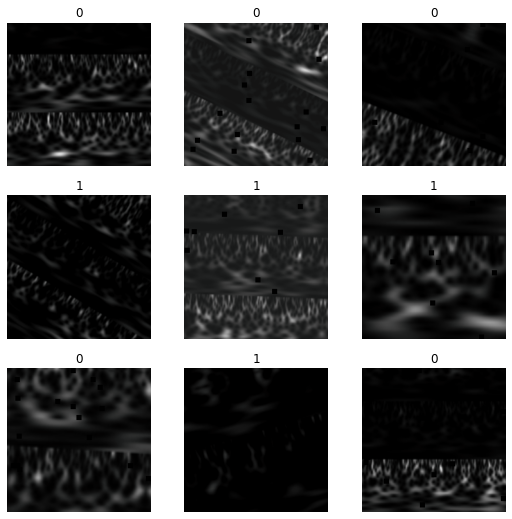

In [18]:
# We can call show_batch() to see what a sample of a batch looks like.
dls.show_batch()

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">GPU Efficient Networks</p>

![](https://raw.githubusercontent.com/idstcv/GPU-Efficient-Networks/master/misc/genet_acc_speed_curve.jpg)

<p style = "font-family: garamond; font-size: 20px; font-style: normal; border-radius: 10px 10px; text-align:center"> The proposed design space is optimized for fast GPU inference. In this space, it uses a semi-automatic NAS to help us design GPU-Efficient Networks. GENets use full convolutions in low-level stages and depth-wise
convolution and/or bottleneck structure in high-level stages.<br>This design is inspired by the observation that convolutional kernels in the high-level stages are more likely to have low intrinsic rank and different types of convolutions have different kinds of efficiency on GPU.<br>

In [19]:
model = GENet.genet_large(pretrained=True, root='../input/genetparam/')

In [20]:
wandb.init(project='G2Net-Fastai', job_type='train', name = 'GPU Efficient Network Large', config = {'competetion': 'G2Net','_wandb_kernel':'tang'})

wandb: Currently logged in as: tanishqgautam (use `wandb login --relogin` to force relogin)


In [21]:
# Group together some dls, a model, and metrics to handle training
learn = Learner(dls, model, metrics = RocAucBinary(), cbs=[WandbCallback(log='all'), SaveModelCallback()]) 

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.0010000000474974513)

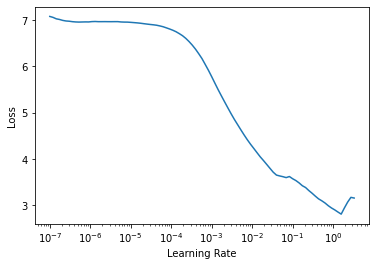

In [22]:
# Choosing a good learning rate
learn.lr_find()

In [23]:
# We can use the fine_tune function to train a model with this given learning rate
learn.fine_tune(4, base_lr=0.0010000000474974513)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.700600,0.689283,0.498413,13:12


Better model found at epoch 0 with valid_loss value: 0.6892825961112976.


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.691286,0.694557,0.516610,11:27
1,0.683535,0.677646,0.532255,10:58
2,0.668756,0.665979,0.553461,10:52
3,0.668331,0.662080,0.516255,10:52


Better model found at epoch 0 with valid_loss value: 0.6945571303367615.
Better model found at epoch 1 with valid_loss value: 0.6776455640792847.
Better model found at epoch 2 with valid_loss value: 0.6659790873527527.
Better model found at epoch 3 with valid_loss value: 0.6620795726776123.


<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center"><a href = 'https://wandb.ai/tanishqgautam/G2Net-Fastai'>Check out the Weights and Biases Dashboard here $\rightarrow$ </a></p>

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Final Metrics</p><br>

<center><img src="https://i.imgur.com/HBzvpxZ.png" width="1500" alt="metrics" /></center>

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Prediction Samples</p><br>

<center><img src="https://i.imgur.com/qoFuEyk.png" width="1500" alt="metrics" /></center>

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Evaluation Metrics</p><br>

<center><img src="https://i.imgur.com/wy8lpLe.png" width="1500" alt="metrics" /></center>

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Submission</p><br>

In [25]:
test_path = Path('../input/g2net-gravitational-wave-detection')
sample = pd.read_csv(test_path/'sample_submission.csv')
sample

,id,target
0,00005bced6,0.5
1,0000806717,0.5
2,0000ef4fe1,0.5
3,00020de251,0.5
4,00024887b5,0.5
...,...,...
225995,ffff4125f1,0.5
225996,ffff9d32a6,0.5
225997,ffff9f4c1f,0.5
225998,ffffa19693,0.5


In [26]:
_sample = sample.copy()
_sample['id'] = _sample['id'].map(lambda x: f'{path}/test_cqt/test_cqt/{x}.png')
test_dl = dls.test_dl(_sample)

In [27]:
_sample.head()

,id,target
0,../input/g2net-constant-q-transformed/test_cqt/test_cqt/00005bced6.png,0.5
1,../input/g2net-constant-q-transformed/test_cqt/test_cqt/0000806717.png,0.5
2,../input/g2net-constant-q-transformed/test_cqt/test_cqt/0000ef4fe1.png,0.5
3,../input/g2net-constant-q-transformed/test_cqt/test_cqt/00020de251.png,0.5
4,../input/g2net-constant-q-transformed/test_cqt/test_cqt/00024887b5.png,0.5


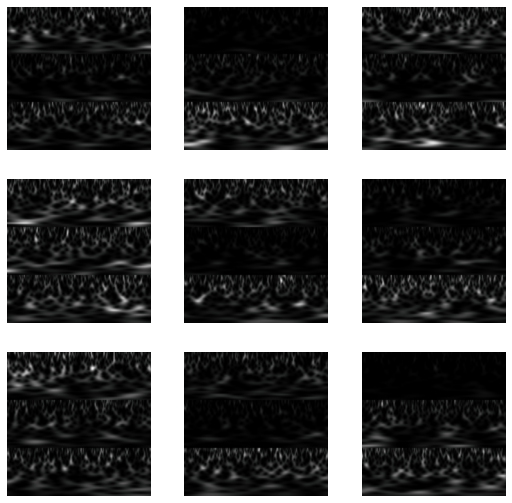

In [28]:
test_dl.show_batch()

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Test Time Augmentation (TTA)</p>

<p style = "font-family: garamond; font-size: 20px; font-style: normal; border-radius: 10px 10px; text-align:center"> Similar to what Data Augmentation is doing to the training set, the purpose of Test Time Augmentation is to perform random modifications to the test images. Thus, instead of showing the regular, “clean” images, only once to the trained model, we will show it the augmented images several times. We will then average the predictions of each corresponding image and take that as our final guess. <br><br>
The reason why it works is that, by averaging our predictions, on randomly modified images, we are also averaging the errors. The error can be big in a single vector, leading to a wrong answer, but when averaged, only the correct answer stand out.</p>

In [31]:
a, _ = learn.tta(dl=test_dl, n=1)
pred = a.argmax(dim=1).numpy()
sample['target'] = pred

Error in callback <function _WandbInit._resume_backend at 0x7fdb0ecbf290> (for pre_run_cell):


Exception: The wandb backend process has shutdown

Error in callback <function _WandbInit._pause_backend at 0x7fdb0ecbf200> (for post_run_cell):


Exception: The wandb backend process has shutdown

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/wandb_run.py", line 201, in check_status
    status_response = self._interface.communicate_stop_status()
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/interface/interface.py", line 742, in communicate_stop_status
    resp = self._communicate(req, timeout=timeout, local=True)
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/interface/interface.py", line 544, in _communicate
    return self._communicate_async(rec, local=local).get(timeout=timeout)
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/interface/interface.py", line 549, in _communicate_async
    raise Exception("The wandb backend process has shutdown")
Exception: The wandb backend 

In [32]:
sample.to_csv('submission.csv',index=False)

Error in callback <function _WandbInit._resume_backend at 0x7fdb0ecbf290> (for pre_run_cell):


Exception: The wandb backend process has shutdown

Error in callback <function _WandbInit._pause_backend at 0x7fdb0ecbf200> (for post_run_cell):


Exception: The wandb backend process has shutdown